# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data
df.tail()

,AGG,SPY
,close,close
2019-12-24 00:00:00-05:00,112.375,321.26
2019-12-26 00:00:00-05:00,112.480,322.91
2019-12-27 00:00:00-05:00,112.620,322.86
2019-12-30 00:00:00-05:00,112.630,321.10
2019-12-31 00:00:00-05:00,112.370,321.89


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
avg_daily_returns = daily_returns.mean()
avg_returns_agg = avg_daily_returns.iloc[0]
avg_returns_spy = avg_daily_returns.iloc[1]
# print(daily_returns_spy)
type(avg_returns_spy)

numpy.float64

In [7]:
# Compute daily volatility
total_std = daily_returns.std()

# volatility.iloc[0]
std_dev_agg = total_std.iloc[0]
std_dev_spy = total_std.iloc[1]
type(std_dev_agg)

numpy.float64

In [8]:
# Save the last day's closing price
agg_last_price = df.iloc[-1, 0]
spy_last_price = df.iloc[-1, 1]


In [9]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

# Creating dataframes to hold values.
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [10]:
# Running the simulations.
for n in range(number_simulations):

    # Creating list of prices.
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulating the returns.
    for records in range(number_records):
        
        # Calculating the simulated price.
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_returns_agg, std_dev_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_returns_spy, std_dev_spy))
        
        # Adding to a list.
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Adding in the simulated prices.
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculating the daily returns.
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Setting the portfolio weights. 60% SPY and 40% AGG
    weights = [0.40, 0.60]
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

portfolio_cumulative_returns

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000475,1.000536,0.998808,1.005395,1.011798,0.994450,0.997249,1.013279,1.000868,0.995375,...,1.002066,0.992708,1.001800,1.002671,0.996472,1.003160,1.001638,1.006801,0.998172,0.994764
2,1.008876,1.004700,1.003591,0.996710,1.009571,0.994245,0.994211,1.007202,1.000225,0.993033,...,1.005759,0.994515,1.003316,1.006181,0.997471,0.991772,1.002764,1.005410,0.996136,0.998870
3,1.008286,1.004228,1.003771,0.998232,1.007751,0.987666,0.998226,1.001363,1.000229,1.001276,...,1.006771,0.988440,1.004116,1.010566,0.993292,0.994452,1.008273,0.999143,0.998654,1.003328
4,1.013962,1.006575,1.008494,1.002635,1.013664,0.990970,1.003240,0.995492,1.002046,1.006035,...,1.004195,0.992120,1.004722,1.004421,0.994842,0.993780,1.005723,1.002247,0.996961,1.004094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,191.877430,172.770957,175.240247,136.947375,173.793376,406.267389,103.532182,206.988187,179.548103,154.221161,...,205.458500,209.248707,200.686847,150.148136,211.122641,418.371282,175.293827,464.490072,134.794816,206.938704
7557,191.475651,171.047304,174.777670,136.931716,174.167842,406.199034,102.913247,208.781603,179.633062,153.038722,...,205.186824,208.619528,201.335360,148.944061,211.236387,421.274198,175.697601,466.135886,135.211498,206.537338
7558,190.898094,170.849385,175.567492,137.140048,173.579831,407.939476,102.968642,209.606646,180.464746,153.117809,...,205.343974,209.264055,202.010108,148.513862,212.260393,421.353789,175.731788,462.718516,134.235376,206.950357
7559,190.540663,170.741196,175.824068,137.501635,175.136285,405.930009,102.720595,209.303936,179.439883,152.988074,...,205.719971,210.316575,200.818946,148.566339,213.425291,420.458209,175.992434,461.510627,133.433833,206.063636


In [11]:
# Check that the simulation ran successfully
# wouldn't this be printing the dataframe?

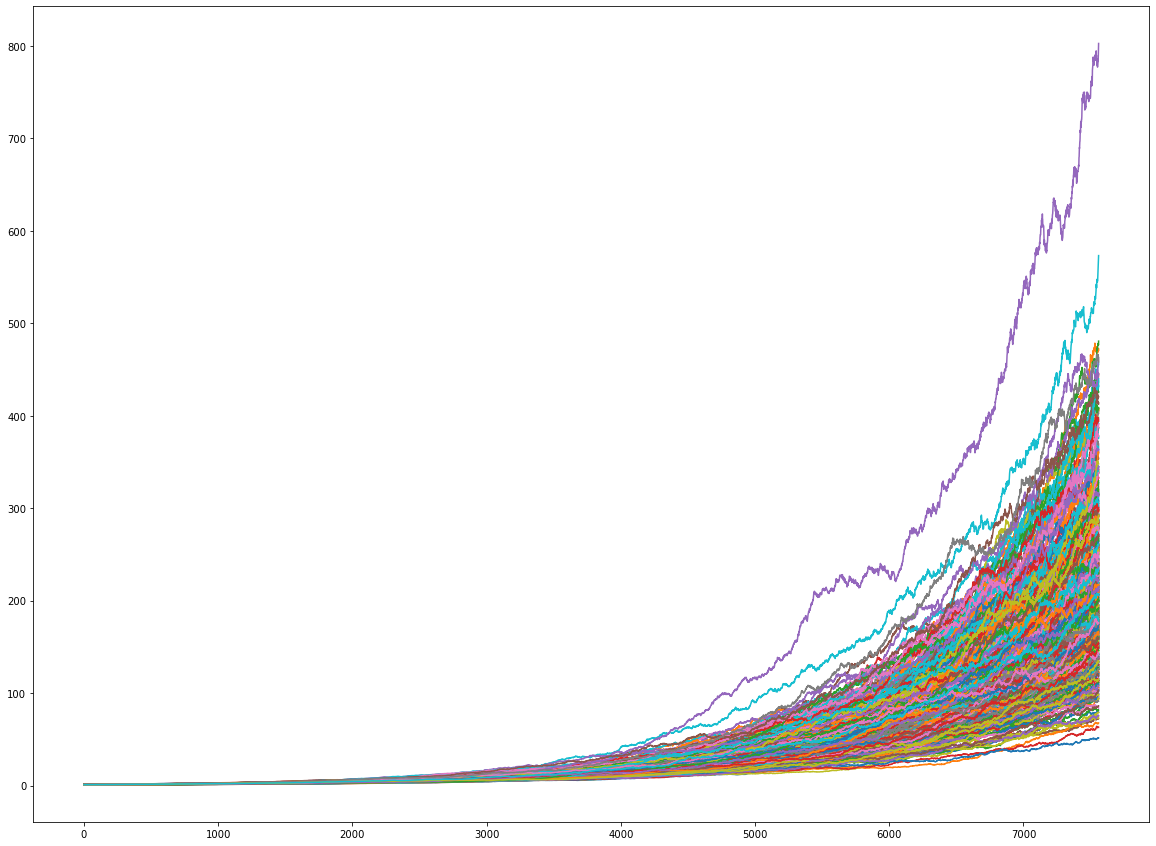

In [12]:
# Visualize the Simulation
portfolio_cumulative_returns.plot(figsize = (20,15), legend = False)

In [13]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[(20 * 252), :]
ending_cumulative_returns

# Selected the 20th year, since we ran the simulations for 30 years.
# The code for the last year in our simulation is below.
# ending_cumulative_returns = portfolio_cumlative_returns.iloc[-1, :]

0      33.537819
1      30.996853
2      27.882568
3      24.812726
4      47.086509
         ...    
495    64.011178
496    39.656300
497    73.266235
498    18.492578
499    40.051933
Name: 5040, Length: 500, dtype: float64

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# same as above?

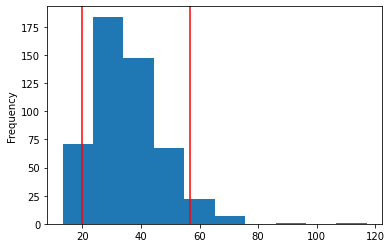

In [15]:
# Display the 90% confidence interval for the ending returns
confidence_interval_90 = ending_cumulative_returns.quantile(q = [.05, .95])
ending_cumulative_returns.plot.hist()
plt.axvline(confidence_interval_90.iloc[0], color = "r")
plt.axvline(confidence_interval_90.iloc[1], color = "r")

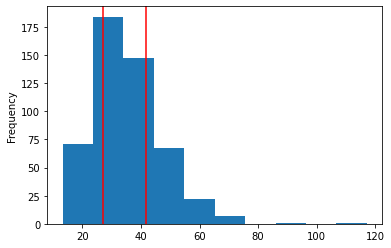

In [18]:
# Visualize the distribution of the ending returns
# same as above?
# ending_cumulative_returns.plot.hist()
# finding the 50% confidence interval
confidence_interval_50 = ending_cumulative_returns.quantile(q = [.25, .75])
ending_cumulative_returns.plot.hist()
plt.axvline(confidence_interval_50.iloc[0], color = "r")
plt.axvline(confidence_interval_50.iloc[1], color = "r")

---

In [19]:
confidence_interval_50

0.25    27.132614
0.75    41.751310
Name: 5040, dtype: float64

In [20]:
confidence_interval_90

0.05    19.735732
0.95    56.886259
Name: 5040, dtype: float64

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [54]:
# Compute cumulative returns
confidence_intervals = ending_cumulative_returns.quantile(q=[.1, .5, .9])

print(f"At 30 years, the 10th percentile of your expected returns is {confidence_intervals.iloc[0]:.2f}% of your initial investment")
print("\n")
print(f"At 30 years, the 50th percentile of your expected returns is {confidence_intervals.iloc[1]:.2f}% of your initial investment")
print("\n")
print(f"At 30 years, the 90th percentile of your expected returns is {confidence_intervals.iloc[2]:.2f}% of your initial investment")


At 30 years, the 10th percentile of your expected returns is 22.29% of your initial investment


At 30 years, the 50th percentile of your expected returns is 33.76% of your initial investment


At 30 years, the 90th percentile of your expected returns is 50.90% of your initial investment


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [55]:
# Set initial investment
initial_investment = 20000

# Compute expected portfolio return
ten_percent = initial_investment * confidence_intervals.iloc[0]
fifty_percent = initial_investment * confidence_intervals.iloc[1]
ninety_percent = initial_investment * confidence_intervals.iloc[2]

print(f"At 30 years, you can expect ${ten_percent:.2f} at the 10th percentile.")
print("\n")
print(f"At 30 years, you can expect ${fifty_percent:.2f} at the 50th percentile.")
print("\n")
print(f"At 30 years, you can expect ${ninety_percent:.2f} at the 90th percentile.")


At 30 years, you can expect $445842.25 at the 10th percentile.


At 30 years, you can expect $675297.56 at the 50th percentile.


At 30 years, you can expect $1017968.37 at the 90th percentile.


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [67]:
# Set Plaid's projected income
monthly_income = 500
projected_yearly_income = 6085
monthly_avg_expenses = 10645.24

# Calculate the 4% withdrawal for the ending return as retirement income
retirement_income = (.04 * (ten_percent)) / 12

# Determine if the retirement income meets or exceeds the current projected income
if retirement_income > monthly_income:
    print(f"By withdrawing 4% of your portfolio, your monthly withrawls are going to be greater than your income by ${(retirement_income - monthly_income):.2f}.")
else:
    print(f"By withdrwaing 4% of your portfolio, your monthly income is going to be greater than your withdrawls by ${(monthly_income - retirement_income):.2f}.")

By withdrawing 4% of your portfolio, your monthly withrawls are going to be greater than your income by $986.14.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [64]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
new_investment = (initial_investment * .5) + initial_investment

new_ten_percent = confidence_intervals.iloc[0] * new_investment

new_retirement_income = (new_ten_percent * .04) / 12

if new_retirement_income > monthly_income:
    print(f"By withdrawing 4% of your portfolio, your monthly withrawls are going to be greater than your income by ${(new_retirement_income - monthly_income):.2f}.")
else:
    print(f"By withdrwaing 4% of your portfolio, your monthly income is going to be greater than your withdrawls by ${(monthly_income - new_retirement_income):.2f}.")

By withdrawing 4% of your portfolio, your monthly withrawls are going to be greater than your income by $1729.21.


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [60]:
# Compute projected returns
f = ending_cumulative_returns.quantile(.05)

fifty = ending_cumulative_returns.quantile(.5)

nine = ending_cumulative_returns.quantile(.95)

# numbers of intervals (5, 50, 95), so 3 simulations needed
number_simulations = 3 

number_records = 252

# this stays the same
agg_last_price = df.iloc[-1, 0]
spy_last_price = df.iloc[-1, 1]

count = 0

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 days
#     change up count
#     if count == 
    for records in range(number_records):
        
        #adding in count so I don't have to do three completely different sets of code and then concat the whole datasets together.
        if count == 0:
            d = f
            # Calculate the simulated price using the last price within the list
            simulated_agg_price = simulated_agg_prices[-1] * (d)
            simulated_spy_price = simulated_spy_prices[-1] * (d)
        
            # Append the simulated price to the list
            simulated_agg_prices.append(simulated_agg_price)
            simulated_spy_prices.append(simulated_spy_price)
        elif count == 1:
            d = fifty
            # Calculate the simulated price using the last price within the list
            simulated_agg_price = simulated_agg_prices[-1] * (d)
            simulated_spy_price = simulated_spy_prices[-1] * (d)
        
            # Append the simulated price to the list
            simulated_agg_prices.append(simulated_agg_price)
            simulated_spy_prices.append(simulated_spy_price)
        else:
            d = nine
            # Calculate the simulated price using the last price within the list
            simulated_agg_price = simulated_agg_prices[-1] * (d)
            simulated_spy_price = simulated_spy_prices[-1] * (d)
        
            # Append the simulated price to the list
            simulated_agg_prices.append(simulated_agg_price)
            simulated_spy_prices.append(simulated_spy_price)
#         print(simulated_agg_prices)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% JNJ; 40% MU)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
#     print(count)
    count += 1

# Print records from the DataFrame
portfolio_cumulative_returns.tail()


C:\Users\dovu9\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in double_scalars
C:\Users\dovu9\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars
C:\Users\dovu9\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in double_scalars
C:\Users\dovu9\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars
C:\Users\dovu9\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in double_scalars
C:\Users\dovu9\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in double_scalars


,0,1,2
248,inf,inf,inf
249,inf,inf,inf
250,inf,inf,inf
251,inf,inf,inf
252,inf,inf,inf


In [61]:
d = simulated_agg_prices[-1] * (1 + f)
print(nine)

56.94859246995272


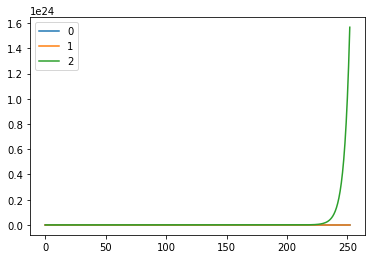

In [97]:
# Plot the cumulative returns over time
portfolio_cumulative_returns.plot.line()

In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
